<a href="https://colab.research.google.com/github/Giovannisb/Portfolio_data_science/blob/master/Avalia%C3%A7%C3%A3o_de_cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src='https://image.freepik.com/fotos-gratis/cartoes-de-credito_144627-16725.jpg'></center>

#Como as empresas avaliam seus clientes.

Operações que envolvam um certo período de tempo entre a posse do ativo e su respectivo pagamento, ocorrem de uma forma ou de outra sob condições de crédito. Isso implica consequentemente em uma relação de confiança entre as partes, por outro lado, surge também o risco da operação não ser executada corretamente, seja pelo não pagamento ou um pagamento de valor inferior ao estipulado.

Seguindo essas premissas, as empresas de ofertam serviços de cartões de crédito, sentem a necessidade de avaliar melhor se o seu cliente. Desta forma, surgiu a necessidade de avaliar a capacidade do cliente em honrar os termos contratados e garantir o pagamento.

Nesta análise irei fazer uma abordagem de como essa avaliação funciona utilizando data science e machine learning, criando um modelo preditivo para avaliar se o cliente pode ou não ser favorecido com um crédito extra.

In [1]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# definir o estilo do seaborn para os plots
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

In [3]:
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


Estou utilizando um dataset de uma empresa não identificada que disponibilizou seus dados abertos [neste link](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0).

Após importar o dataset, utilizo a biblioteca `Pandas` para criar um `DataFrame`, para me ajudar na visualização dos dados e já de cara podemos tirar alguns insights:
* Existe uma coluna `id`, anônima, que representa um identificador único do cliente.
* A variável alvo para analisar o risco de *default* (inadimplência) está na coluna `target_default`.
* As colunas `['score_3', 'score_4', 'score_5']` são numéricas e as colunas `['score_1', 'score_2']` estão codificadas de alguma maneira. 
* existem outras variáveis que apresentam algum tipo de codificação, como `['reason', 'state', 'zip', 'channel', 'job_name', 'real_state']` que estão codificadas.
* A coluna `target_fraud` seria a variável alvo de outro modelo para este mesmo *dataset*.

In [4]:
print("Dimensões do DataFrame")
print("Linhas: ", df.shape[0])
print("Colunas: ", df.shape[1])

Dimensões do DataFrame
Linhas:  45000
Colunas:  43


In [5]:
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


Nosso `DataFrame` possuim 45 mil linhas e 43 colunas, bastante dado para ser avaliado, e numa análise das estatísticas do nosso `DataFrame` podemos observar algumas coisas.

* A coluna `external_data_provider_credit_checks_last_2_year` possui valores mínimos, máximos e desvio-padrão iguais a zero.
* A coluna `reported_income` apresenta valores *inf*, que irão interferir na análise e modelo. Substituiremos valores do tipo `np.inf` por `np.nan` para trabalhar com os dados.
* A coluna `external_data_provider_email_seen_before` apresenta o valor mínimo de -999, o que é estranho ao se considerar as outras informações. Após verificar de maneira mais aprofundada, chegou-se a conclusão que esses dados são *outliers* ou foram tratados inadequadamente. Substituiremos os valores iguais a -999 por `np.nan`.

Vamos realizar o levantamento dos tipos de variáveis que compõem o *DataFrame* a fim de estabelecer a divisão entre as variáveis numéricas e as variáveis categóricas e a porcentagem de valores ausentes.

In [6]:
print("Tipos das variáveis:")
print(df.dtypes)

Tipos das variáveis:
ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip                

In [7]:
print("Valores nulos em nosso dataset: ")
print(((df.isnull().sum() / df.shape[0]) * 100).sort_values(ascending=False))

Valores nulos em nosso dataset: 
target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                       

Em relação à porcentagem de valores ausentes identificados neste *dataset*:

* Diversas variáveis como `['target_fraud', 'last_amount_borrowed', 'last_borrowed_in_months', 'ok_since', 'external_data_provider_credit_checks_last_2_year']` possuem mais da metade dos valores ausentes.

* As variáves `['external_data_provider_credit_checks_last_year', 'credit_limit', 'n_issues']` possuem entre 25-34% do seus valores ausentes.

* A variável alvo `target_default` contém valores nulos que serão eliminados do *dataset*.

Neste projeto, o caso mais extremo (`target_fraud`) não representa um problema, pois é uma variável alvo que não interessa para a análise de risco de inadimplência. Já as demais *features* deverão ser usadas com o devido cuidado.

Uma outra análise interessante de se fazer diz respeito à contagem de valore únicos por features. Muitas vezes, variáveis numéricas podem esconder classes/categorias que melhor representariam uma *feature*, ou revelar uma quantidade elevada de classes para "variáveis categóricas".

In [8]:
print("Valores únicos:")
print(df.nunique().sort_values())

Valores únicos:
external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               4

A contagem de valores únicos mostra que as colunas `external_data_provider_credit_checks_last_2_year` e `channel` apresentam um único valor possível. Como não ha maiores informações sobre cada *feature* iremos descartar as duas colunas para o modelo de *Machine Learning*.

Também se percebe que `profile_phone_number` possui 45 mil valores únicos, não trazendo provavelmente nenhuma informação que possa contribuir para a análise.

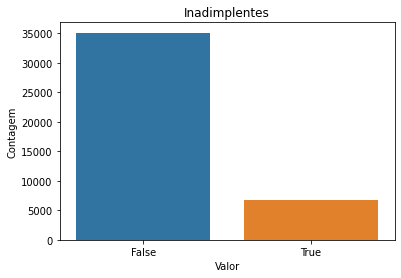

Proporção entre Inadimplentes no Dataset:
False    77.955556
True     14.802222
Name: target_default, dtype: float64


In [9]:
fig, ax = plt.subplots()
sns.countplot('target_default', data=df, ax=ax)
ax.set_title("Inadimplentes")
ax.set_xlabel("Valor")
ax.set_ylabel("Contagem")
plt.show()

print("Proporção entre Inadimplentes no Dataset:")
print((df['target_default'].value_counts() / df.shape[0]) * 100)

Observando o balanceamento da variável `target_default`, está bastante desbalanceada, podendo enviezar nosso modelo preditivo para classificar mais falsos do que positivos.

##Limpeza dos dados

In [10]:
df_clean = df.copy()

# substituir inf por nan em reported_income 
df_clean['reported_income'] = df_clean['reported_income'].replace(np.inf,
                                                                  np.nan)

# descartar as colunas ids, target_fraud,
# external_data_provider_credit_checks_last_2_year e channel
df_clean.drop(labels=['ids', 'target_fraud',
                      'external_data_provider_credit_checks_last_2_year',
                      'channel'], axis=1, inplace=True)

#  substituir -999 em external_data_provider_email_seen_before por NaN
df_clean.loc[df_clean['external_data_provider_email_seen_before'] == -999.0,
             'external_data_provider_email_seen_before'] = np.nan

# elminar colunas sem informação aparente ou que demandam mais pesquisa
drop_var = ['reason', 'zip', 'job_name', 'external_data_provider_first_name',
            'lat_lon', 'shipping_zip_code', 'user_agent', 'profile_tags',
            'application_time_applied', 'email', 'marketing_channel',
            'profile_phone_number', 'shipping_state']
df_clean.drop(labels=drop_var, axis=1, inplace=True)

# elminar as entradas onde target_default é NaN
df_clean.dropna(subset=['target_default'], inplace=True)

Apesar de não haver maiores informações sobre as *features*, podemos assumir como premissa que muitos valores são nulos devido a dois fatores:

1. Há alguns itens que não são obrigatórios durante a etapa de preenchimento dos formulários, como a informação sobre o perfil do cliente no Facebook; e
2. Não existe observação alguma referente à coluna, como é caso das colunas `['last_amount_borrowed', 'last_borrowed_in_months', 'n_issues']`.

De maneira geral, para as variáveis que se enquadram no segundo caso, os valores `NaN` serão substituidos por zero. Para as variáveis numéricas, será adotado o valor da mediana, e para as categóricas o valor mais frequente.

In [11]:
from sklearn.impute import SimpleImputer

num_df = df_clean.select_dtypes(exclude='object').columns
cat_df = df_clean.select_dtypes(include='object').columns

# substituição de valores ausentes
df_clean.last_amount_borrowed.fillna(value=0, inplace=True)
df_clean.last_borrowed_in_months.fillna(value=0, inplace=True)
df_clean.n_issues.fillna(value=0, inplace=True)

# variáveis numéricas
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_clean.loc[:,num_df])
df_clean.loc[:,num_df] = imputer.transform(df_clean.loc[:,num_df])

# variáveis categóricas
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_clean.loc[:,cat_df])
df_clean.loc[:,cat_df] = imputer.transform(df_clean.loc[:,cat_df])

In [12]:
# verificar a quantidade de dados nulos
df_clean.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                    

##Criando o modelo de predição
<center><img src='https://image.freepik.com/fotos-gratis/cerebro-artificial-azul-brilhante-e-dados-binarios-abstratos_163855-131.jpg'></center>

Para este modelo, irei utilizar o XGBoost uma vez que este vem se destacando e apresentando bons resultados em problemas similares a este.

Não foram feitas análises com detalhamento profundo dos dados e nem um "tunning" dos parâmetros do modelo. Foi feita apenas uma normalização dos dados numéricos e a codificação das colunas categóricas.

In [13]:
from sklearn.preprocessing import StandardScaler

scaled_df = df_clean.copy()

# normalizar as colunas numéricas
num_cols = scaled_df.drop('target_default',
                         axis=1).select_dtypes(exclude='object').columns

scaled_df[num_cols] = StandardScaler().fit_transform(scaled_df[num_cols].values)

In [14]:
from sklearn.preprocessing import LabelEncoder

encoded_df = scaled_df.copy()
# extrair as colunas categóricas
cat_cols = encoded_df.select_dtypes('object').columns

# codificar cada coluna categórica
for col in cat_cols:
  encoded_df[col+'_encoded'] = LabelEncoder().fit_transform(encoded_df[col])
  encoded_df.drop(col, axis=1, inplace=True)

In [15]:
from sklearn.model_selection import train_test_split

# separar as variáveis independentes da variável alvo
X = encoded_df.drop('target_default', axis=1).select_dtypes(exclude='object')
y = encoded_df['target_default']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# instanciando o modelo e treinando o mesmo
ml_model = XGBClassifier(learning_rate=0.01, n_estimators=1000,
                         max_depth=3, subsample = 0.9,
                         colsample_bytree = 0.1, gamma=1,
                         random_state=42)
ml_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [18]:
# previsões e probabilidades em cima do dataset de teste
y_pred = ml_model.predict(X_test)

# ver performance do algoritmo
print("\nAccuracy Score:")
print (accuracy_score(y_test, y_pred))


Accuracy Score:
0.8405334185099417


In [23]:
!pip install scikit-plot -q
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc

print(classification_report(y_test, y_pred))

#área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))


              precision    recall  f1-score   support

       False       0.84      1.00      0.91     10525
        True       0.53      0.00      0.01      1998

    accuracy                           0.84     12523
   macro avg       0.69      0.50      0.46     12523
weighted avg       0.79      0.84      0.77     12523

AUC: 0.5019



##Conclusão

Com um "tunning" dos parâmetros do modelo sem passar por um "aperfeiçoamento", tivemos uma acurácia de 84,05%, um ótimo resultado, mas um valor de ACU mediano, 50%.